In [1]:
import sys
import pandas as pd
from tqdm import tqdm
from detoxify import Detoxify

sys.path.append("../")

In [2]:
data_df = pd.read_json("../dataset/blip_laion_cc_sbu_558k.json")

In [3]:
gpt_messages = []

for index, row in data_df.iterrows():
    conversations = row['conversations']
    for conversation in row['conversations']:
        if conversation['from'] == 'gpt':
            gpt_messages.append(
                {
                    'id': row['id'],
                    'message': conversation['value']
                }
            )    

In [6]:
def process_batch(batch):
    """
    Process a batch of records through Detoxify model and add all toxicity scores.
    
    Parameters:
    batch (list of dict): A list of dictionaries with 'id' and 'message'.
    
    Returns:
    list of dict: A list of dictionaries with 'id', 'message', and all toxicity scores.
    """
    messages = [entry['message'] for entry in batch]
    ids = [entry['id'] for entry in batch]
    # Get predictions
    results = Detoxify('original').predict(messages)
    
    # Combine results with original data
    processed_batch = []
    for i, (id_, message) in enumerate(zip(ids, messages)):
        entry = {'id': id_, 'message': message}
        entry.update({k: results[k][i] for k in results.keys()})
        processed_batch.append(entry)
    
    return processed_batch

def process_dataset(data, batch_size=1000):
    """
    Process the entire dataset in batches with a progress bar and return a DataFrame with all toxicity scores.
    
    Parameters:
    data (list of dict): A list of dictionaries representing the dataset.
    batch_size (int): Number of records to process in each batch.
    
    Returns:
    pd.DataFrame: A DataFrame with 'id', 'message', and all toxicity score columns.
    """
    all_results = []
    total_batches = (len(data) + batch_size - 1) // batch_size  # Calculate total number of batches
    # Process in batches with a progress bar
    for i in tqdm(range(0, len(data), batch_size), total=total_batches, desc="Detecting Toxicity"):
        batch = data[i:i+batch_size]
        processed_batch = process_batch(batch)
        all_results.extend(processed_batch)
    # Convert to DataFrame
    df = pd.DataFrame(all_results)
    return df

In [ ]:
# Process the dataset
result_df = process_dataset(gpt_messages, batch_size=100)

# Save the result to a JSON file
result_df.to_json('../dataset/toxicity_detection.json', orient='records', lines=True)

Detecting Toxicity:  30%|███████████████▉                                      | 1650/5582 [2:33:48<7:18:55,  6.70s/it]

In [2]:
toxicity_scores_df = pd.read_json("../dataset/toxicity_detection.json", lines=True)

In [3]:
toxicity_scores_df

,id,message,toxicity_score
0,4539375,select luxury furniture 3 - inch gel memory fo...,0.000677
1,2239345,a grey watch with an army style strap,0.001014
2,5947502,a dragon kite flying in the blue sky stock images,0.000791
3,5116462,$ 10 - cute cheap printed mini dress - khaki m...,0.000748
4,2017886,augmented reality using aruco markers in opencv,0.000664
...,...,...,...
558123,524806,paper quilled letters of the alphabet h with c...,0.000796
558124,3755035,"a jabra corded headset with usb sync, power co...",0.000704
558125,2176227,"an apple ii computer, with a computer monitor ...",0.000897
558126,600956,us03498792 figure 1 from a patent drawing of a...,0.000835


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.widgets import Slider

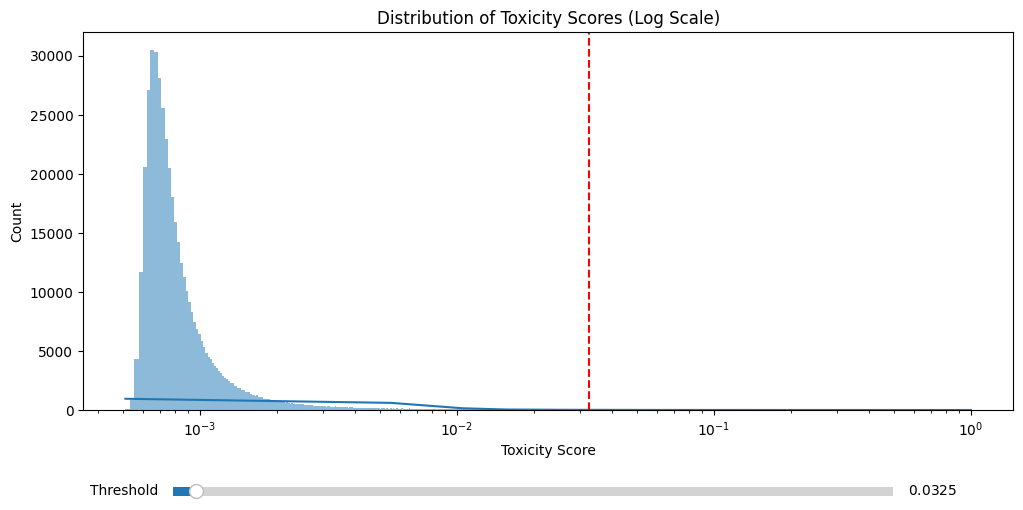

count    558128.000000
mean          0.011032
std           0.060880
min           0.000512
25%           0.000695
50%           0.000849
75%           0.001580
max           0.999143
Name: toxicity_score, dtype: float64
Percentile: 90.0%, Threshold: 0.009795, Filtered: 55813 (10.00%)
Percentile: 90.1%, Threshold: 0.009994, Filtered: 55255 (9.90%)
Percentile: 90.19999999999999%, Threshold: 0.010197, Filtered: 54697 (9.80%)
Percentile: 90.29999999999998%, Threshold: 0.010399, Filtered: 54139 (9.70%)
Percentile: 90.39999999999998%, Threshold: 0.010604, Filtered: 53581 (9.60%)
Percentile: 90.49999999999997%, Threshold: 0.010821, Filtered: 53023 (9.50%)
Percentile: 90.59999999999997%, Threshold: 0.011044, Filtered: 52464 (9.40%)
Percentile: 90.69999999999996%, Threshold: 0.011249, Filtered: 51906 (9.30%)
Percentile: 90.79999999999995%, Threshold: 0.011496, Filtered: 51348 (9.20%)
Percentile: 90.89999999999995%, Threshold: 0.011730, Filtered: 50790 (9.10%)
Percentile: 90.99999999999994%, Th

In [10]:
# Create the main plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(bottom=0.25)

# Plot the histogram with log scale
sns.histplot(data=toxicity_scores_df, x='toxicity_score', kde=True, ax=ax)
ax.set_xscale('log')
ax.set_title('Distribution of Toxicity Scores (Log Scale)')
ax.set_xlabel('Toxicity Score')
ax.set_ylabel('Count')

# Initial threshold (let's start with 95th percentile)
initial_threshold = toxicity_scores_df['toxicity_score'].quantile(0.95)

# Add a line for the threshold
line = ax.axvline(x=initial_threshold, color='r', linestyle='--')

# Add a slider for the threshold
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(ax_slider, 'Threshold', toxicity_scores_df['toxicity_score'].min(), toxicity_scores_df['toxicity_score'].max(), 
                valinit=initial_threshold, valstep=0.001)

# Update function for the slider
def update(val):
    line.set_xdata(val)
    filtered = toxicity_scores_df[toxicity_scores_df['toxicity_score'] >= val]
    ax.set_title(f'Distribution of Toxicity Scores (Log Scale)\n'
                 f'Threshold: {val:.6f}, '
                 f'Filtered: {len(filtered)} ({len(filtered)/len(toxicity_scores_df)*100:.2f}%)')
    fig.canvas.draw_idle()

slider.on_changed(update)

# Show the plot
plt.show()

# Print statistics
print(toxicity_scores_df['toxicity_score'].describe())

# Function to find optimal threshold based on percentiles
def find_optimal_threshold(df, start_percentile=90, end_percentile=99, step=0.1):
    percentiles = np.arange(start_percentile, end_percentile + step, step)
    thresholds = [df['toxicity_score'].quantile(p/100) for p in percentiles]
    
    for p, t in zip(percentiles, thresholds):
        filtered = df[df['toxicity_score'] >= t]
        print(f"Percentile: {p}%, Threshold: {t:.6f}, "
              f"Filtered: {len(filtered)} ({len(filtered)/len(df)*100:.2f}%)")
    
    # You can adjust this logic based on your specific requirements
    suggested_percentile = 95
    return df['toxicity_score'].quantile(suggested_percentile/100)

optimal_threshold = find_optimal_threshold(toxicity_scores_df)
print(f"\nSuggested optimal threshold: {optimal_threshold:.6f}")

# Example of applying the threshold
filtered_df = toxicity_scores_df[toxicity_scores_df['toxicity_score'] < optimal_threshold]
print(f"\nOriginal dataset size: {len(toxicity_scores_df)}")
print(f"Filtered dataset size: {len(filtered_df)}")
print(f"Removed {len(toxicity_scores_df) - len(filtered_df)} highly toxic sentences")

In [8]:
len(toxicity_scores_df[toxicity_scores_df['toxicity_score']>0.8])

892

In [9]:
for index, row in toxicity_scores_df[toxicity_scores_df['toxicity_score']>0.8].iterrows():
    print(row['id'], row['message'], row['toxicity_score'])
    

1030565 a blue t shirt with white text saying, shut ya face cause im watching slappin'nfaace 0.84655267
3887736 a brunette lady in a lace lingersuit has her tits spread 0.9690027237000001
3772469 the complete idiot's mini guide to creating your own wordpress com blog 0.9071250558
6441895 the group sex party of the black babes gets fucked 0.9958964586000001
1193536 blonde haired pornstar is sucking her boss cocks 0.9980883002000001
2058881 redhead milo gets her pussy tits pumped and fucked 0.9982706308
3895026 a lady with long red hair has a deep penetration and gets her throat fucked by a black cock 0.9987939596000001
4146966 a pretty young woman in a taxi is enjoying her pussy orgasm 0.9883846045
824832 lawn cuts die bundle 0.8105263114
845321 mens joggers in black 0.9007818103
1308556 an older lady spreading her sexy pussyes on the sofa 0.9806134701
2392914 a blonde chick with huge booies is fucked by a guy 0.9975612164000001
3019612 the thinker is the great thinker, a man is an idio